### Imports

In [40]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

### Data Preparation

In [33]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

### Model Building

#### Sampling Layer

In [51]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [53]:
mean = np.array([[0.1,1.2,0.2,0.8]], dtype=np.float32)
standard_deviation = np.array([[0.2,0.5,0.8,1.3]], dtype=np.float32)
z = Sampler()(mean, standard_deviation)

In [54]:
print(z.numpy())
print(z.shape)

[[-1.0493346  1.3778746 -1.8494227 -0.6476286]]
(1, 4)


#### Encoder

In [55]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [56]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 14, 14, 32)           320       ['input_8[0][0]']             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 7, 7, 64)             18496     ['conv2d_9[0][0]']            
                                                                                                  
 flatten_4 (Flatten)         (None, 3136)                 0         ['conv2d_10[0][0]']           
                                                                                            

#### Decoder

In [57]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [58]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 1)         289 

### Custom VAE model

In [59]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [60]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30


547/547 [==============================] - 36s 56ms/step - total_loss: 206.0532 - reconstruction_loss: 203.4529 - kl_loss: 2.6003
Epoch 2/30
547/547 [==============================] - 31s 56ms/step - total_loss: 167.4607 - reconstruction_loss: 164.1901 - kl_loss: 3.2706
Epoch 3/30
547/547 [==============================] - 32s 59ms/step - total_loss: 159.3619 - reconstruction_loss: 155.9935 - kl_loss: 3.3684
Epoch 4/30
547/547 [==============================] - 30s 55ms/step - total_loss: 156.2802 - reconstruction_loss: 152.8531 - kl_loss: 3.4270
Epoch 5/30
547/547 [==============================] - 29s 52ms/step - total_loss: 154.7021 - reconstruction_loss: 151.2354 - kl_loss: 3.4667
Epoch 6/30
547/547 [==============================] - 30s 55ms/step - total_loss: 153.4051 - reconstruction_loss: 149.9316 - kl_loss: 3.4734
Epoch 7/30
547/547 [==============================] - 33s 60ms/step - total_loss: 152.6815 - reconstruction_loss: 149.2066 - kl_loss: 3.4750
Epoch 8/30
547/547 [====

1/1 [==============================] - 0s 26ms/step


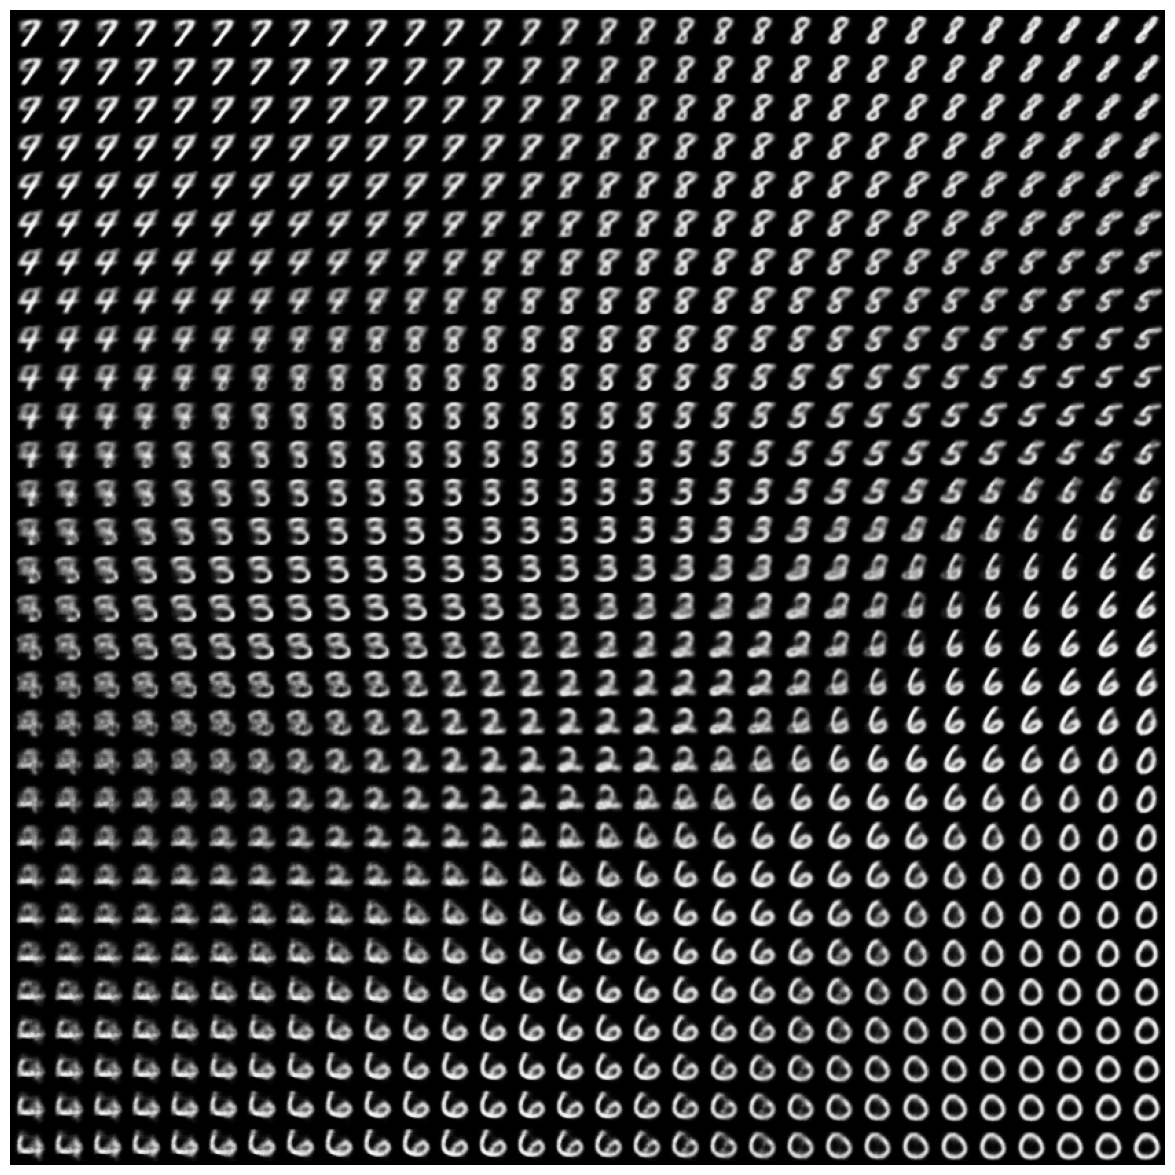

In [62]:
import matplotlib.pyplot as plt

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

1875/1875 [==============================] - 6s 3ms/step


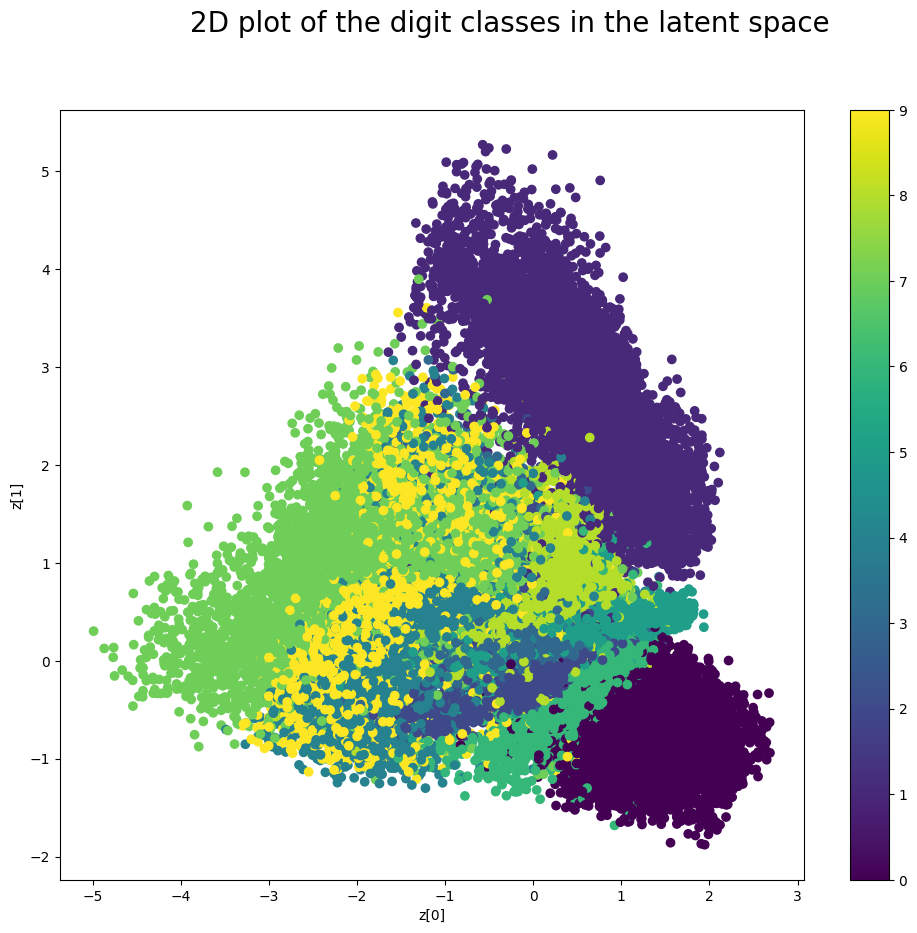

In [64]:
def plot_label_clusters(encoder, decoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _,  = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.suptitle("2D plot of the digit classes in the latent space", fontsize = 20)
    plt.show()


(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)

In [65]:
z =  tf.keras.backend.random_normal(shape=(1, 2))
x_decoded = decoder.predict(z)
digit = x_decoded[0].reshape(28,28)

1/1 [==============================] - 0s 33ms/step


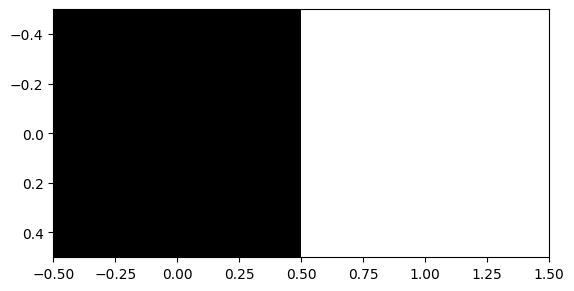

In [66]:
plt.imshow(z, cmap='gray')

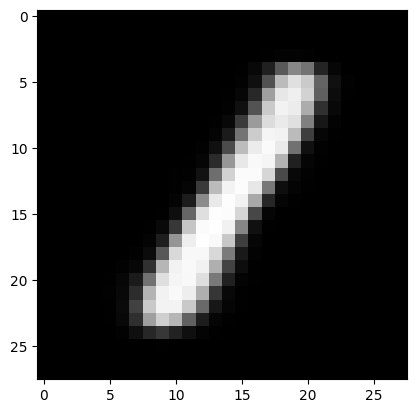

In [67]:
plt.imshow(digit, cmap='gray')

In [74]:
def generate_and_save_images(test_data):
    z_mean, z_log_var = encoder.predict(test_data)
    z = Sampler()(z_mean, z_log_var)
    predictions = decoder.predict(z)
    for i in range(predictions.shape[0]):
        plt.imshow(predictions[i, :, :, 0], cmap='gray')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png')
    plt.show()

313/313 [==============================] - 1s 2ms/step


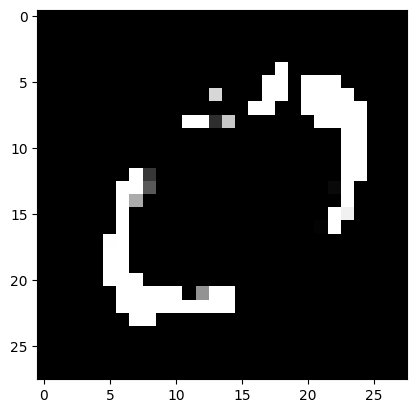

In [75]:
generate_and_save_images(x_test)